<a href="https://colab.research.google.com/github/amanyyasrr/amanyyasrr/blob/main/currency_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from scipy.spatial import distance
from skimage.metrics import structural_similarity as ssim
import pickle
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



In [ ]:
def load_reference_images(folder_path):
    reference_images = {}
    for filename in os.listdir(folder_path):
        path = os.path.join(folder_path, filename)
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            reference_images[filename] = image
    return reference_images

def compare_images(img1, img2):
    img1 = cv2.resize(img1, (300, 150))
    img2 = cv2.resize(img2, (300, 150))
    return np.mean((img1 - img2) ** 2)


In [ ]:
ref_folder = "/content/drive/MyDrive/Real"
test_path = "/content/WhatsApp-Image-2023-06-20-at-3.06.48-PM.jpeg"


In [ ]:
reference_images = load_reference_images(ref_folder)

In [ ]:
test_image = cv2.imread(test_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)


In [ ]:
min_score = float('inf')
best_match = None

for name, ref_img in reference_images.items():
    score = compare_images(test_image, ref_img)
    print(f"Comparing with {name} => Score: {score:.2f}")
    if score < min_score:
        min_score = score
        best_match = name

print(f"\n Closest Match: {best_match} with Score: {min_score:.2f}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_image)
axes[0].set_title("Test Image")
axes[0].axis("off")

axes[1].imshow(reference_images[best_match])
axes[1].set_title(f"Best Match: {best_match}")
axes[1].axis("off")

plt.show()

In [ ]:
print(f"\n Closest Match: {best_match} with Score: {min_score:.2f}")

In [ ]:
best_match_img = reference_images[best_match]

In [ ]:
save_path = "/content/drive/MyDrive/best_match_result.jpg"
cv2.imwrite(save_path, cv2.cvtColor(best_match_img, cv2.COLOR_RGB2BGR))

print(f" Best match image saved at: {save_path}")

 Best match image saved at: /content/drive/MyDrive/best_match_result.jpg


In [ ]:
reference_image = cv2.imread("/content/drive/MyDrive/best_match_result.jpg")
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

In [ ]:
test_image = cv2.imread(test_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)


In [ ]:
gray_ref = cv2.cvtColor(reference_image, cv2.COLOR_RGB2GRAY)
gray_test = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)


In [ ]:
h, w = gray_ref.shape
crop_x, crop_y = int(w * 0.25), int(h * 0.25)
crop_w, crop_h = int(w * 0.5), int(h * 0.5)

In [ ]:
center_ref = gray_ref[crop_y:crop_y + crop_h, crop_x:crop_x + crop_w]
center_test = gray_test[crop_y:crop_y + crop_h, crop_x:crop_x + crop_w]

In [ ]:
r_ref, g_ref, b_ref = cv2.split(reference_image)
r_test, g_test, b_test = cv2.split(test_image)

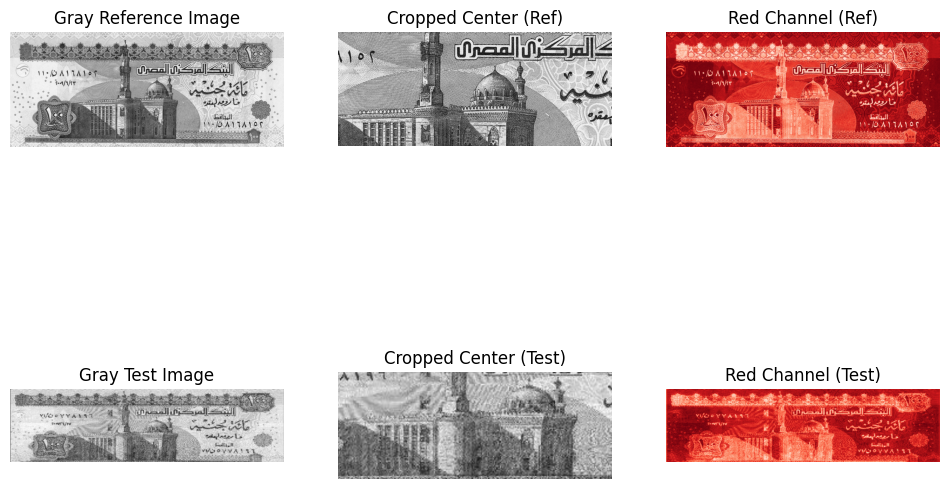

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(gray_ref, cmap="gray")
axes[0, 0].set_title("Gray Reference Image")
axes[0, 1].imshow(center_ref, cmap="gray")
axes[0, 1].set_title("Cropped Center (Ref)")
axes[0, 2].imshow(r_ref, cmap="Reds")
axes[0, 2].set_title("Red Channel (Ref)")


axes[1, 0].imshow(gray_test, cmap="gray")
axes[1, 0].set_title("Gray Test Image")
axes[1, 1].imshow(center_test, cmap="gray")
axes[1, 1].set_title("Cropped Center (Test)")
axes[1, 2].imshow(r_test, cmap="Reds")
axes[1, 2].set_title("Red Channel (Test)")


for ax in axes.ravel():
    ax.axis("off")

plt.show()

In [ ]:
def extract_texture_features(image):
    distances = [1, 2, 3, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    return [contrast, correlation, energy, homogeneity]


In [ ]:
texture_features_ref = extract_texture_features(center_ref)
texture_features_test = extract_texture_features(center_test)

In [ ]:
print("Features (Reference Image):", texture_features_ref)
print("Features (Test Image):", texture_features_test)

Features (Reference Image): [np.float64(3166.588193378465), np.float64(0.5545278404913921), np.float64(0.006647760729724582), np.float64(0.0366868719104633)]
Features (Test Image): [np.float64(641.4066570694326), np.float64(0.8260602360148837), np.float64(0.010405079504486152), np.float64(0.07068225271707279)]


In [ ]:
def extract_shape_features(image):
    print("Image Shape Before Processing:", image.shape)


    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    labeled_img = label(binary)
    regions = regionprops(labeled_img)


    if len(regions) > 0:
        eccentricity = regions[0].eccentricity
        extent = regions[0].extent
        solidity = regions[0].solidity
    else:
        eccentricity, extent, solidity = 0, 0, 0

    return [eccentricity, extent, solidity]


In [ ]:
shape_features_ref = extract_shape_features(center_ref)
shape_features_test = extract_shape_features(center_test)

Image Shape Before Processing: (214, 512)
Image Shape Before Processing: (201, 512)


In [ ]:
print("Shape Features (Reference Image):", shape_features_ref)
print("Shape Features (Test Image):", shape_features_test)

Shape Features (Reference Image): [0.3199141092643034, np.float64(0.7428618802851932), np.float64(0.7725281925716453)]
Shape Features (Test Image): [0.8193724264976461, np.float64(0.5646775058066822), np.float64(0.7446764645244898)]


In [ ]:
height, width = gray_ref.shape
gray_test_resized = cv2.resize(gray_test, (width, height))

In [ ]:
dims_path = "real_dimensions.json"

try:
    with open(dims_path, "r") as f:
        dims = json.load(f)
except FileNotFoundError:
    dims = {
        "width": width,
        "height": height
    }
    with open(dims_path, "w") as f:
        json.dump(dims, f)

In [ ]:
feature_vector_ref = texture_features_ref + shape_features_ref
feature_vector_test = texture_features_test + shape_features_test
euclidean_dist = distance.euclidean(feature_vector_ref, feature_vector_test)
ssim_score = ssim(gray_ref, gray_test_resized)

In [ ]:
test_h, test_w = gray_test.shape

def check_dimensions(test_w, test_h, real_w, real_h, tol=5):
    return abs(test_w - real_w) <= tol and abs(test_h - real_h) <= tol

dims_check = check_dimensions(test_w, test_h, dims["width"], dims["height"])

In [ ]:
height, width = gray_ref.shape
gray_test_resized = cv2.resize(gray_test, (width, height))


feature_vector_ref = texture_features_ref + shape_features_ref
feature_vector_test = texture_features_test + shape_features_test
euclidean_dist = distance.euclidean(feature_vector_ref, feature_vector_test)


ssim_score = ssim(gray_ref, gray_test_resized)

In [ ]:
print(f"Correct Euclidean Distance: {euclidean_dist:.4f}")
print(f"Correct SSIM Score: {ssim_score:.4f}")
print(f"Dimensions Match: {'Yes' if dims_check else 'No'}")


Correct Euclidean Distance: 2525.1816
Correct SSIM Score: 0.1074
Dimensions Match: No


In [ ]:
if euclidean_dist < 1500 and ssim_score > 0.5 and dims_check:
    print("🔵 Real Pound ")
else:
    print("🔴 Fake Pound ")



🔴 Fake Pound 
